In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import clear_output

# Create a directory for saving generated images
if not os.path.exists('generated_images'):
    os.makedirs('generated_images')

In [2]:
# Load and preprocess data (example using MNIST dataset for simplicity)
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize to [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [3]:
# Define the generator model
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(LeakyReLU())
    model.add(Reshape((7, 7, 256)))
    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(LeakyReLU())
    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(LeakyReLU())
    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    return model

In [4]:
# Define the discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(1))
    return model

In [5]:
# Create the models
generator = make_generator_model()
discriminator = make_discriminator_model()

C:\Users\1803s\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\1803s\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
# Define the loss and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [7]:
# Define the training loop
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        for image_batch in dataset:
            train_step(image_batch)
        
        # Produce images for the GIF as you go
        clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # Print progress
        print(f'Time for epoch {epoch + 1} is {time.time()-start:.2f} sec')
    
    # Generate after the final epoch
    clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

    # Generate after the final epoch
    clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [8]:
import time

In [9]:
# Function to generate and save images
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('generated_images/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [10]:
# Set up training parameters
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

In [11]:
# Seed to visualize progress
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [12]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [13]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())
print(tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None))

Num GPUs Available:  0
False
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
False


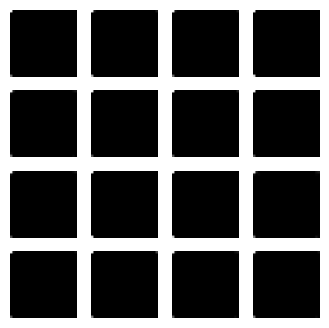

In [14]:
# Start training
train(train_dataset, EPOCHS)

In [15]:
import cv2
import glob

img_array = []
for filename in sorted(glob.glob('generated_images/image_at_epoch_*.png')):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width, height)
    img_array.append(img)

out = cv2.VideoWriter('generated_video.avi', cv2.VideoWriter_fourcc(*'DIVX'), 10, size)

for img in img_array:
    out.write(img)

out.release()